In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [19]:
import sys
sys.path.append('../scripts/')
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [10]:
def pearson(dataarray1,dataarray2):
    a = np.log(dataarray1.values) 
    b = np.log(dataarray2.values)
    mask = np.isfinite(a) & np.isfinite(b)
    return pearsonr(a[mask],b[mask])

def plot_correlation(darray1,darray2):
    ind, bins = np.histogram(darray1, bins=30, range=(1e-12,1e-7));
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

    g = sns.jointplot(x=darray1,y=darray2,kind='scatter',dropna=True,
                 xlim=(1e-14,1e-5),ylim=(1e-14,1e-5), marginal_kws={'bins':logbins})
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
    g.ax_joint.set_xlabel(r'$\epsilon$ (RC)')
    g.ax_joint.set_ylabel(r'$\epsilon$ (MLE Kraichnan)')

    r2, pvalue = pearson(darray1,darray2)
    g.ax_joint.annotate(rf'r$^2$ = {r2:2.2f}'+'\n'+rf'p = {pvalue:2.3f}',(0.2,0.78),xycoords='figure fraction')

    g.ax_joint.plot(darray1, darray1, color='k', lw=0.2);

### Load uncleaned data:

In [48]:
ds = xr.open_dataset('../data/test_profiles//variable_dof8.nc')

In [51]:
ds

<xarray.Dataset>
Dimensions:          (f_cps: 20, time: 391)
Coordinates:
  * f_cps            (f_cps) float64 0.125 0.175 0.225 0.3 ... 28.33 39.08 53.9
  * time             (time) datetime64[ns] 2017-09-25T06:40:35 ... 2017-09-25T07:45:35
    z                (time) float64 ...
    k_rpm            (time, f_cps) float64 ...
Data variables:
    dof              (f_cps) float64 ...
    p                (time) float64 ...
    N2               (time) float64 ...
    N                (time) float64 ...
    T                (time) float64 ...
    dTdz             (time) float64 ...
    w                (time) float64 ...
    k_cpm            (time, f_cps) float64 ...
    f_rps            (time, f_cps) float64 ...
    noise_cps        (time, f_cps) float64 ...
    noise_rpm        (time, f_cps) float64 ...
    snr1             (time, f_cps) float64 5.612e+05 1.654e+05 ... nan nan
    snr2             (time, f_cps) float64 5.612e+05 1.654e+05 ... nan nan
    corrdTdzsp1_rpm  (time, f_cps) fl

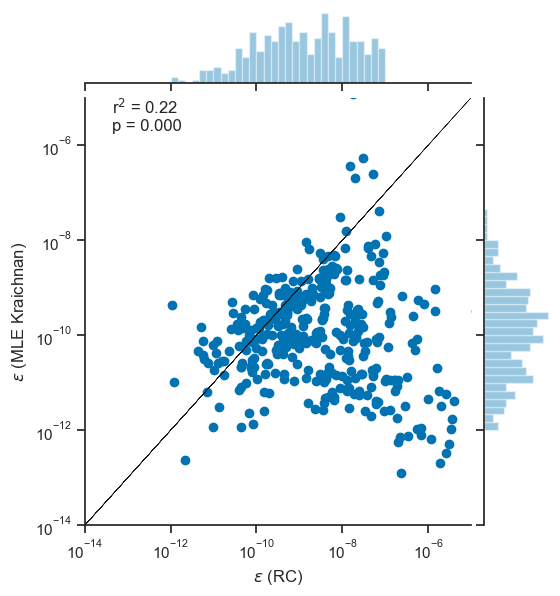

In [32]:
plot_correlation(ds.eps1_rc, ds.eps1_kra)

### Ren-Chieh's QC

1. thresholds for dtdz, chi, and kt
2. remove times of sensor malfunction
3. combine the two sensors

In [33]:
ds = threshold_for_chi(ds,p)
ds = rm_sensor_malfunction(ds,p)
ds = combine_two_sensors(ds,p)

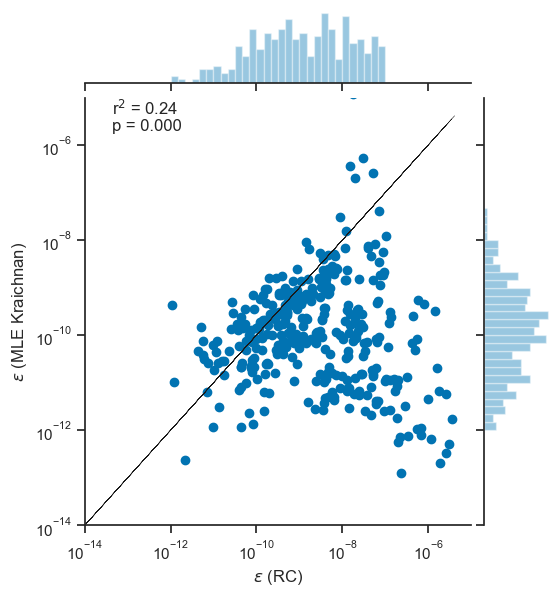

In [34]:
plot_correlation(ds.eps_rc, ds.eps1_kra)

### MAD

In [50]:
ds = mad(ds,p)

In [41]:
ds['eps1_kra'] = ds['eps1_kra'].where( ds['mad1_kra']<1)
ds['eps1_bat'] = ds['eps1_bat'].where( ds['mad1_bat']<1)

ds['eps2_kra'] = ds['eps2_kra'].where( ds['mad2_kra']<1)
ds['eps2_bat'] = ds['eps2_bat'].where( ds['mad2_bat']<1)

ValueError: x and y must have length at least 2.

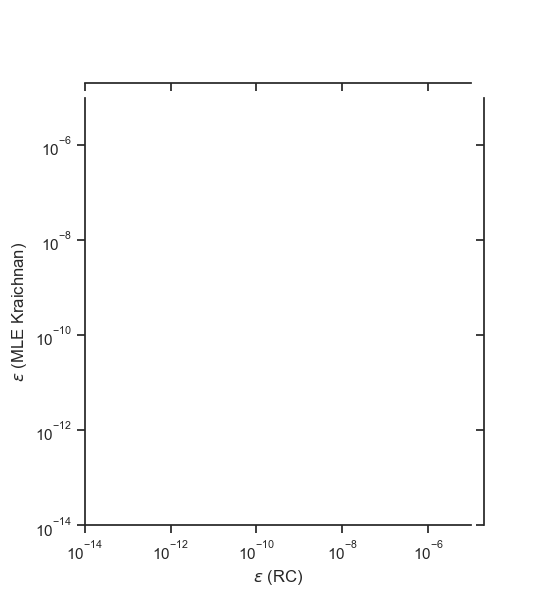

In [42]:
plot_correlation(ds.eps_rc, ds.eps1_kra)

In [47]:
ds.mad1_kra

<xarray.DataArray 'mad1_kra' ()>
array(1.86958016)